This notebook shall demonstrate simple SAR processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c0
import skradar

%matplotlib widget

# Scene Setup
See the ```single_static_target``` example for a detailed description of the configuration of radar, target, and scene.

## Radar Setup

In [2]:
B = 1e9
fc = 76.5e9
N_f = 256  # number of fast-time samples
fs_f = 1e6  # fast-time sampling rate

Ts_s = (N_f-1)*1/fs_f
N_s = 1

lambd = c0 / fc

radar_pos = np.array([[0], [0], [10]])
tx_pos = np.array([[0], [0], [0]])
rx_pos = np.array([[0], [0], [0]])

radar = skradar.FMCWRadar(B=B, fc=fc, N_f=N_f, T_f=1 / fs_f, T_s=Ts_s,
                          N_s=N_s, tx_pos=tx_pos, rx_pos=rx_pos,
                          pos=radar_pos, name='First radar')

#v_max = lambd / (4 * Ts_s)  # Maximum unambiguous velocity
radar.vel = np.array([[0], [0], [0]])  # stop-hop movements will be defined later

## Target Setup

In [3]:
target_lst = list()

z_start = 10
z_stop = z_start+20*lambd
x = 0
y = 5
for z in np.arange(z_start, z_stop, 4*lambd):
    target_lst.append(skradar.Target(rcs=1, pos=np.array(
        [[x], [y], [z]]), name=''))

scene = skradar.Scene([radar], target_lst)

print(f'There are {len(target_lst)} targets in the scene')

There are 6 targets in the scene


# Radar Signal Simulation and Range Processing
Simulate chirps and perform range-compression. SAR measurement positions are simulated using the stop-hop assumption. For this purpose the radar positions are simply modified in a stepwise manner without using actually defining a velocity.

In [4]:
z_range = 4  # zero padding factor in range
N_x = 30  # number of x-positions
N_z = 30  # number of z-positions

rp_sar = np.zeros((N_x, N_z, z_range*N_f), dtype=complex)
pos_sar = np.zeros((N_x, N_z, 3))

vel = 10
time_step = 2e-3

for z_cntr in range(N_z):
    if z_cntr % 2 == 0:        
        vel_x = vel  # moving in the x-direction
    else:        
        vel_x = -vel  # moving in the neg. x-direction
    for x_cntr in range(N_x):
        radar.sim_chirps()
        radar.range_compression(zp_fact=z_range)
        rp_sar[x_cntr, z_cntr, :] = radar.rp[0, 0, 0, :]        
        pos_sar[x_cntr, z_cntr, :] = radar.pos[:, 0]
        radar.pos = radar.pos + np.array([[vel_x * time_step], [0], [0]])
    # moving in the z-direction:
    radar.pos = radar.pos + np.array([[0], [0], [vel * time_step]])

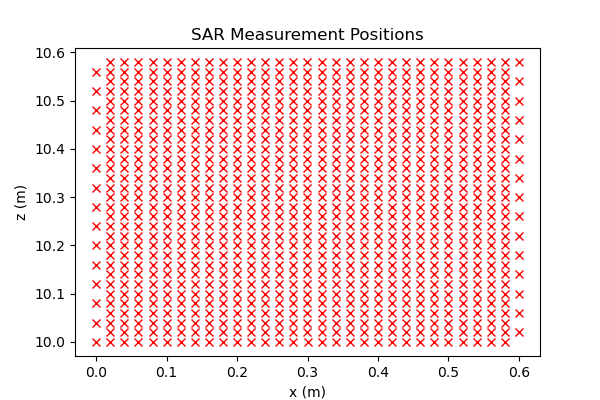

In [5]:
plt.figure(figsize=(6, 4))
plt.clf()
for z_cntr in range(N_z):
    for x_cntr in range(N_x):
        radar_pos = pos_sar[x_cntr, z_cntr, :]
        plt.plot(radar_pos[0], radar_pos[2], 'xr')
plt.title('SAR Measurement Positions')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.show()

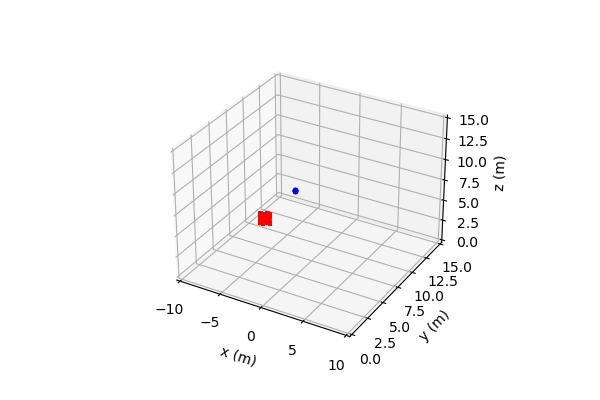

In [6]:
fig = plt.figure(figsize=(6, 4))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
for z_cntr in range(N_z):
    for x_cntr in range(N_x):
        radar_pos = pos_sar[x_cntr, z_cntr, :]
        ax.plot(radar_pos[0], radar_pos[1], radar_pos[2], 'xr')
for target in target_lst:
    ax.plot(target.pos[0, 0], target.pos[1, 0], target.pos[2, 0], '.b')
ax.set_xlim((-10, 10))
ax.set_ylim((0, 15))
ax.set_zlim((0, 15))
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
plt.show();

# SAR Processing Using Backprojection

## Define Image Pixels

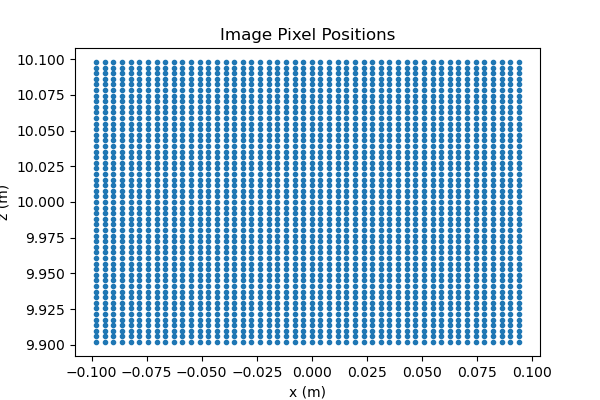

In [7]:
x_range = np.arange(0-25*lambd, 0+25*lambd, lambd)
y_range = 5
z_range = np.arange(10-25*lambd, 10+25*lambd, lambd)
X, Y, Z = np.meshgrid(x_range, y_range, z_range)

im_px = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

plt.figure(figsize=(6, 4))
plt.clf()
plt.plot(im_px[:, 0], im_px[:, 2], '.')
plt.title('Image Pixel Positions')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.show()

## Backprojection

In [8]:
from skradar import backprojection

pos_sar_flat = pos_sar.reshape((-1, pos_sar.shape[-1]))
tx_pos_sar = pos_sar_flat
rx_pos_sar = tx_pos_sar
tx_idcs_vec = np.arange(tx_pos_sar.shape[0])
px_idcs_vec = np.arange(np.prod(X.shape))

px_idcs_mat, tx_idcs_mat  = np.meshgrid(px_idcs_vec, tx_idcs_vec)
rx_idcs_mat = tx_idcs_mat  # no pairs across SAR measurement instances
rp = np.reshape(rp_sar, (tx_pos_sar.shape[0], -1))

image_flat = backprojection(X, Y, Z, (tx_pos_sar.T, rx_pos_sar.T), (tx_idcs_mat.ravel(), rx_idcs_mat.ravel()),
                px_idcs_mat.ravel(), rp, radar.ranges, radar.kw, N_f, posaxis=[0], rangeaxis=1)
image = image_flat.reshape((X.shape[1], X.shape[2]))

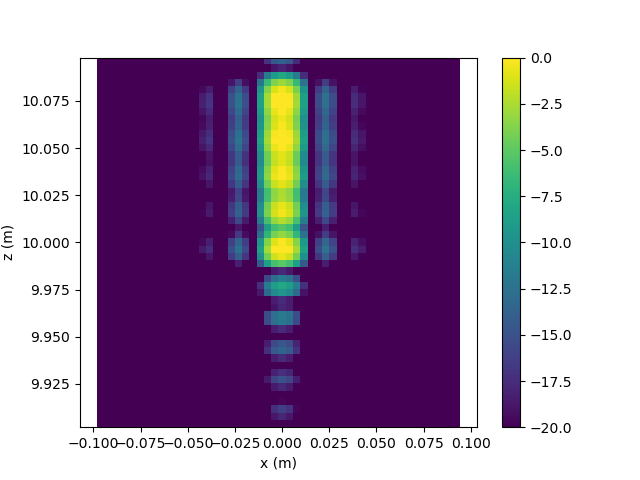

In [9]:
plt.figure()
plt.clf()
left = np.min(x_range)
right = np.max(x_range)
bottom = np.min(z_range)
top = np.max(z_range)
plt.imshow(20*np.log10(np.abs(image.T/(N_x*N_z))),
            extent=(left, right, bottom, top),
            origin='lower')
plt.clim((-20, 0))
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.axis('equal')
plt.show()